In [ ]:
!pip install -q langchain-openai langchain-core langchain-community langgraph xmltodict

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.8/84.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


In [ ]:
import os
with open("/content/api_key.txt") as archivo:
  apikey = archivo.read()
os.environ["OPENAI_API_KEY"] = apikey

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langchain.agents import create_agent
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.tools.pubmed.tool import PubmedQueryRun

In [ ]:
#creacion de herramientas propias

#1-CONVERSION DE MEDIDAS PARA PODER HACER EL CALCULO DE INDICE DE MASA CORPORAL
@tool
def convertir_medidas(pies: float, libras: float) -> dict:
    """
    Convierte pies a centímetros y libras a kilogramos.
    """
    altura_cm = pies * 30.48
    peso_kg = libras * 0.453592
    return {
        "altura_cm": round(altura_cm, 2),
        "peso_kg": round(peso_kg, 2)
    }

#2-CALCULO DEL INDICE DE MASA CORPORAL
@tool
def calcular_imc(peso_kg: float, altura_cm: float) -> dict:
    """
    Calcula el Índice de Masa Corporal (IMC).
    Incluye validaciones para evitar valores físicamente imposibles.
    """

    # Validaciones de tipo
    if peso_kg <= 0 or altura_cm <= 0:
        return {"error": "El peso y la altura deben ser valores positivos."}

    # Rangos humanos razonables
    if peso_kg > 500:
        return {"error": "El peso ingresado es irreal para una persona."}

    if altura_cm < 50 or altura_cm > 300:
        return {"error": "La altura ingresada es irreal para una persona."}

    altura_m = altura_cm / 100
    imc = peso_kg / (altura_m ** 2)

    return {"imc": round(imc, 2)}


#3-CLASIFICACION DE MASA CORPORAL
@tool
def clasificar_imc(imc: float) -> str:
    """
    Clasifica el IMC según rangos de la OMS.
    Incluye validaciones para evitar valores inválidos.
    """

    # Validaciones básicas
    if imc is None:
        return "Error: el IMC no puede ser nulo."

    if not isinstance(imc, (int, float)):
        return "Error: el IMC debe ser un número."

    if imc <= 0:
        return "Error: el IMC debe ser un número positivo."

    if imc > 100:
        return "Error: el IMC ingresado es irreal."

    # Clasificación OMS
    if imc < 18.5:
        return "Bajo peso"
    elif imc <= 24.9:
        return "Adecuado"
    elif imc <= 29.9:
        return "Sobrepeso"
    elif imc <= 34.9:
        return "Obesidad grado 1"
    elif imc <= 39.9:
        return "Obesidad grado 2"
    else:
        return "Obesidad grado 3"
@tool
def buscar_pubmed_reciente(tema: str) -> str:
    """
    Busca 3 artículos científicos recientes en PubMed sobre un tema dado.
    Los resultados se ordenan por fecha (más recientes primero).
    """

    query = f"{tema} AND last 5 years[dp]"

    resultados = pubmed.run(
        query=query,
        max_results=3,
        sort="date"
    )

    if not resultados:
        return "No se encontraron artículos recientes sobre ese tema."

    return resultados
#externa pubmed
pubmed_tool = PubmedQueryRun()

llm = ChatOpenAI(temperature=0)

#todas las tools
tools = [
    convertir_medidas,
    calcular_imc,
    clasificar_imc,
    pubmed_tool
]

memory = MemorySaver()

#prompt
system_prompt = (
 """
Eres un asistente que usa herramientas.
Solo puedes:
- Convertir medidas (pies/libras a cm/kg)
- Calcular el IMC
- Clasificar el IMC según la OMS
- Buscar información médica general en PubMed

Si el usuario pide únicamente el IMC, responde solo con el valor del IMC.
No clasifiques el IMC si el usuario no lo solicita.
No brindes diagnósticos clínicos.
No expliques conceptos médicos por tu cuenta.

Si no sabes la respuesta o no puedes resolver la tarea con las herramientas disponibles,
indica que no puedes ayudar y discúlpate brevemente.

Si una herramienta devuelve un error, informa el error al usuario y no continúes el flujo.

Si la consulta no está relacionada con estos temas, responde que no puedes ayudar.
"""
)
agent = create_agent(
    model=llm,
    tools=tools,
    system_prompt=system_prompt,
    checkpointer=memory
)




In [ ]:
#PRUEBA 1 ESPECIFICANDO EN LIBRAS Y PIES
config = {"configurable": {"thread_id": "abc123"}}

for step in agent.stream(
    {
        "messages": [
            HumanMessage(
                content="Mido 4.6 pies y peso 160 libras. Calculá mi IMC y decime mi clasificación."
            )
        ]
    },
    config,
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Mido 4.6 pies y peso 160 libras. Calculá mi IMC y decime mi clasificación.
================================== Ai Message ==================================
Tool Calls:
  convertir_medidas (call_Dka6BwPCXpSZP8rL0P7HpDDJ)
 Call ID: call_Dka6BwPCXpSZP8rL0P7HpDDJ
  Args:
    pies: 4.6
    libras: 160
================================= Tool Message =================================
Name: convertir_medidas

{"altura_cm": 140.21, "peso_kg": 72.57}
================================== Ai Message ==================================
Tool Calls:
  calcular_imc (call_4EHKjatrWa8MM408GNuWwiqF)
 Call ID: call_4EHKjatrWa8MM408GNuWwiqF
  Args:
    peso_kg: 72.57
    altura_cm: 140.21
================================= Tool Message =================================
Name: calcular_imc

{"imc": 36.91}
================================== Ai Message ==================================
Tool Calls:
  clasificar_imc (call_OJyyNPVixiWLi

In [ ]:
#PRUEBA 2 ESPECIFICANDO EN KG Y METROS
config = {"configurable": {"thread_id": "fgh123"}}

for step in agent.stream(
    {
        "messages": [
            HumanMessage(
                content="Peso 55 kg y mido 1.98 metro, cual es mi indice de masa corporal?"
            )
        ]
    },
    config,
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Peso 55 kg y mido 1.98 metro, cual es mi indice de masa corporal?
================================== Ai Message ==================================
Tool Calls:
  calcular_imc (call_1VPBKTCELLZbjoER5NfGlOLd)
 Call ID: call_1VPBKTCELLZbjoER5NfGlOLd
  Args:
    peso_kg: 55
    altura_cm: 198
================================= Tool Message =================================
Name: calcular_imc

{"imc": 14.03}
================================== Ai Message ==================================

Tu índice de masa corporal es de 14.03.


In [ ]:
#PRUEBA 2b
config = {"configurable": {"thread_id": "fgh123"}}

for step in agent.stream(
    {
        "messages": [
            HumanMessage(
                content="y eso que significa?"
            )
        ]
    },
    config,
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

y eso que significa?
================================== Ai Message ==================================

Tu índice de masa corporal de 14.03 indica que tienes bajo peso según la clasificación de la OMS. Si necesitas más información o consejos sobre tu peso, no dudes en consultarme.


In [ ]:
#PRUEBA 3 PREGUNTANDO CLASIFICACION UNICAMENTE
config = {"configurable": {"thread_id": "ijk123"}}

for step in agent.stream(
    {
        "messages": [
            HumanMessage(
                content="Si mi indice de masa corporal es de 25, estoy bien de peso o no?."
            )
        ]
    },
    config,
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Si mi indice de masa corporal es de 25, estoy bien de peso o no?.
================================== Ai Message ==================================
Tool Calls:
  clasificar_imc (call_PhozcFUAcDNVhIe7wyNnUuBi)
 Call ID: call_PhozcFUAcDNVhIe7wyNnUuBi
  Args:
    imc: 25
================================= Tool Message =================================
Name: clasificar_imc

Sobrepeso
================================== Ai Message ==================================

Tu índice de masa corporal (IMC) es de 25, lo cual indica que tienes sobrepeso según la clasificación de la Organización Mundial de la Salud (OMS).


In [ ]:
#PRUEBA 4 PIDIENDO AYUDA CON EL SOBREPESO
config = {"configurable": {"thread_id": "ijk123"}}

for step in agent.stream(
    {
        "messages": [
            HumanMessage(
                content="Que me recomiendas para el sobrepeso?"
            )
        ]
    },
    config,
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Que me recomiendas para el sobrepeso?
================================== Ai Message ==================================

Lo siento, no puedo proporcionar recomendaciones médicas específicas. Te sugiero que consultes con un profesional de la salud, como un médico o un nutricionista, para obtener un plan personalizado y seguro para abordar el sobrepeso. Si tienes alguna otra pregunta o necesitas información general, ¡estaré aquí para ayudarte!


In [ ]:
#PRUEBA 5 PREGUNTA RANDOM
config = {"configurable": {"thread_id": "lmn123"}}

for step in agent.stream(
    {
        "messages": [
            HumanMessage(
                content="Cual es la capital de Lima?"
            )
        ]
    },
    config,
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Cual es la capital de Lima?
================================== Ai Message ==================================

Lo siento, no puedo ayudar con esa pregunta. ¿Hay algo más en lo que pueda asistirte?


In [ ]:
#PRUEBA 6 SIN UNIDADES (ESTÁ EN KG Y CM)
config = {"configurable": {"thread_id": "opq123"}}

for step in agent.stream(
    {
        "messages": [
            HumanMessage(
                content="Peso 55 y mido 143, cual es mi indice de masa"
            )
        ]
    },
    config,
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Peso 55 y mido 143, cual es mi indice de masa
================================== Ai Message ==================================
Tool Calls:
  calcular_imc (call_uEFq9bvlHgcZNmgEAgOE7Ef5)
 Call ID: call_uEFq9bvlHgcZNmgEAgOE7Ef5
  Args:
    peso_kg: 55
    altura_cm: 143
================================= Tool Message =================================
Name: calcular_imc

{"imc": 26.9}
================================== Ai Message ==================================
Tool Calls:
  clasificar_imc (call_PW5vyqrt8STK0czUsWUgbyKU)
 Call ID: call_PW5vyqrt8STK0czUsWUgbyKU
  Args:
    imc: 26.9
================================= Tool Message =================================
Name: clasificar_imc

Sobrepeso
================================== Ai Message ==================================

Tu índice de masa corporal es de 26.9, lo que indica que estás en la categoría de "Sobrepeso" según la clasificación de la OMS. Si nece

In [ ]:
#PRUEBA 7 SIN UNIDADES (ESTÁ EN KG Y METROS)
config = {"configurable": {"thread_id": "uvw123"}}

for step in agent.stream(
    {
        "messages": [
            HumanMessage(
                content="Peso 83 y mido 1.74. ¿Cuál es mi IMC y cómo se clasifica?"
            )
        ]
    },
    config,
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Peso 83 y mido 1.74. ¿Cuál es mi IMC y cómo se clasifica?
================================== Ai Message ==================================
Tool Calls:
  calcular_imc (call_q62uVolXdsoakyUuL3J0vvv4)
 Call ID: call_q62uVolXdsoakyUuL3J0vvv4
  Args:
    peso_kg: 83
    altura_cm: 174
================================= Tool Message =================================
Name: calcular_imc

{"imc": 27.41}
================================== Ai Message ==================================
Tool Calls:
  clasificar_imc (call_B1FKYTzG8fSmE4TJiz3irygD)
 Call ID: call_B1FKYTzG8fSmE4TJiz3irygD
  Args:
    imc: 27.41
================================= Tool Message =================================
Name: clasificar_imc

Sobrepeso
================================== Ai Message ==================================

Tu IMC es de 27.41, lo que se clasifica como "Sobrepeso" según la Organización Mundial de la Salud (OMS).


In [ ]:
#PRUEBA 8 SIN UNIDADES (ESTÁ EN LIBRAS Y PIES)
config = {"configurable": {"thread_id": "rst123"}}

for step in agent.stream(
    {
        "messages": [
            HumanMessage(
                content="Peso 140 y mido 5, cual es mi indice de masa"
            )
        ]
    },
    config,
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Peso 140 y mido 5, cual es mi indice de masa
================================== Ai Message ==================================
Tool Calls:
  convertir_medidas (call_1sCDwZl0M2FBHQHJnXxthmDP)
 Call ID: call_1sCDwZl0M2FBHQHJnXxthmDP
  Args:
    pies: 5
    libras: 140
================================= Tool Message =================================
Name: convertir_medidas

{"altura_cm": 152.4, "peso_kg": 63.5}
================================== Ai Message ==================================
Tool Calls:
  calcular_imc (call_BC0KC7IUe2Y2FwWgbj0kl3jw)
 Call ID: call_BC0KC7IUe2Y2FwWgbj0kl3jw
  Args:
    peso_kg: 63.5
    altura_cm: 152.4
================================= Tool Message =================================
Name: calcular_imc

{"imc": 27.34}
================================== Ai Message ==================================
Tool Calls:
  clasificar_imc (call_v2zAwfSbrRKsL8vcYFvZuBSu)
 Call ID: call_v2zAwfSb

In [ ]:
#PRUEBA 9 DATOS RANDOM->
"""primera prueba Con un peso de 50000 kg y una altura de 10000 cm, tu Índice de Masa Corporal (IMC) es de 5.0.
Si necesitas más ayuda o información, no dudes en decírmelo."""

config = {"configurable": {"thread_id": "xyz123"}}

for step in agent.stream(
    {
        "messages": [
            HumanMessage(
                content="peso 50000 y mido 10000, cual es mi imc"
            )
        ]
    },
    config,
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

peso 50000 y mido 10000, cual es mi imc
================================== Ai Message ==================================
Tool Calls:
  calcular_imc (call_tmidxS9RwhhI72K92xZ72NpC)
 Call ID: call_tmidxS9RwhhI72K92xZ72NpC
  Args:
    peso_kg: 50000
    altura_cm: 10000
================================= Tool Message =================================
Name: calcular_imc

{"error": "El peso ingresado es irreal para una persona."}
================================== Ai Message ==================================

El peso que ingresaste es irreal para una persona. Por favor, proporciona un peso y altura válidos para calcular tu IMC.


In [ ]:
#PRUEBA 10 ARTICULOS CIENTIFICOS
config = {"configurable": {"thread_id": "abc234"}}

for step in agent.stream(
    {
        "messages": [
            HumanMessage(
                content="Buscá artículos científicos sobre obesidad infantil"
            )
        ]
    },
    config,
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Buscá artículos científicos sobre obesidad infantil
================================== Ai Message ==================================
Tool Calls:
  pub_med (call_fnoIOu001Vz6SmwVssMx37yQ)
 Call ID: call_fnoIOu001Vz6SmwVssMx37yQ
  Args:
    query: childhood obesity
Too Many Requests, waiting for 0.20 seconds...
================================= Tool Message =================================
Name: pub_med

Published: 2026-02-06
Title: Multivariate Trajectories of Eating Disorder Symptoms and Weight Status in 10- to 17-Year-Old Children and Adolescents.
Copyright Information: © 2026 The Author(s). International Journal of Eating Disorders published by Wiley Periodicals LLC.
Summary::
OBJECTIVE: Eating disorders (EDs) often emerge in adolescence, but developmental trajectories across different core features remain largely unclear.
METHOD: The prospective, community-based study included N = 898 participants age

**Capturas de streamlit**

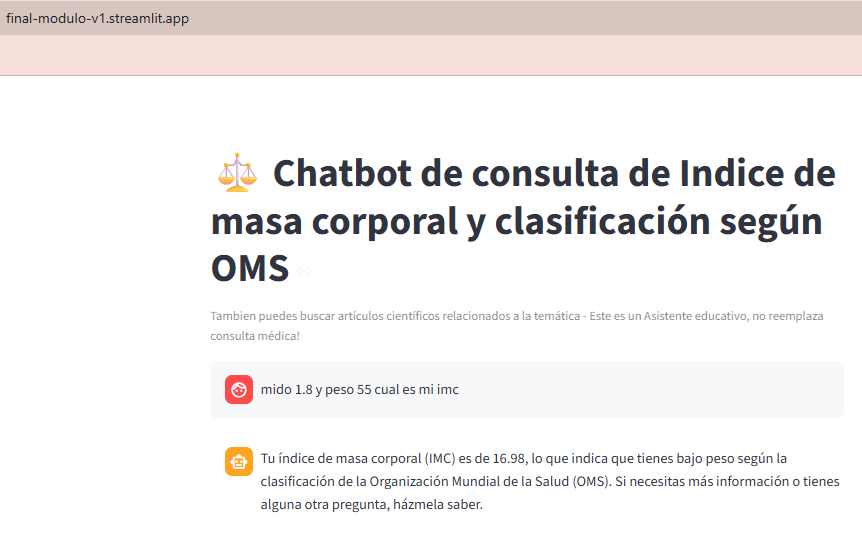

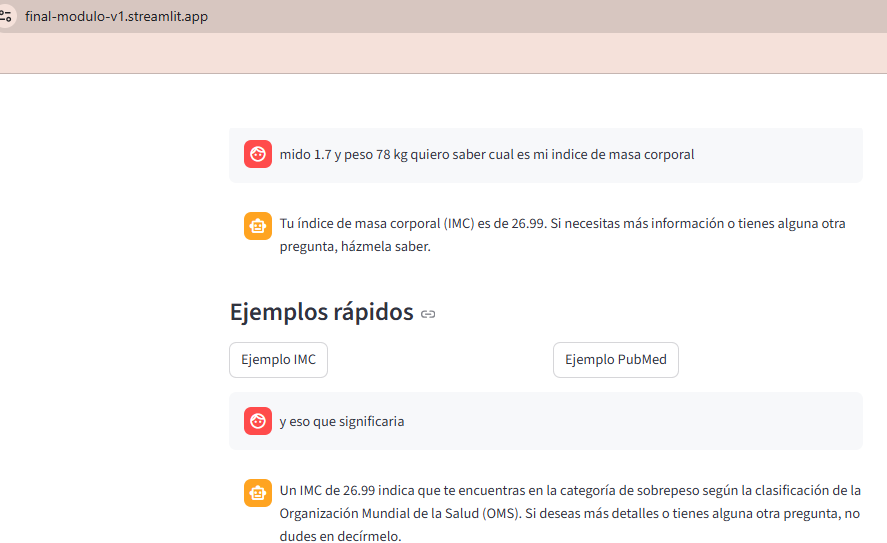

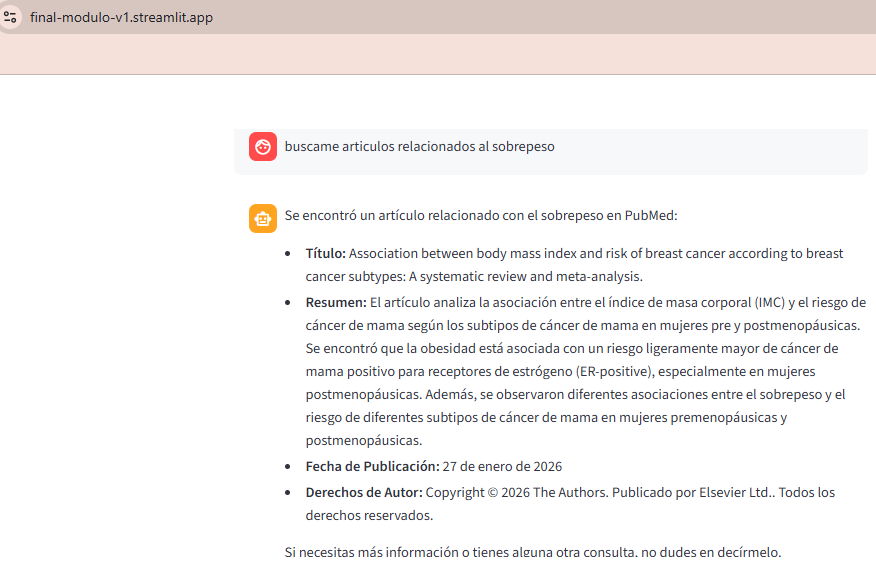